### This notebook provides the code for diversity audit of collections from PPB-2017 dataset

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os, sys, glob, re
from scipy.spatial import distance

from tqdm.notebook import tqdm
from IPython.display import Markdown, display
from matplotlib.pyplot import figure
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure

In [2]:
## Feature extraction using pre-trained VGG-16 network

def getModel():
	#Load the VGG model
	return VGG16(weights='imagenet', include_top=True)	

def getFeatureExtractor():
	model = getModel()
	feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
	return feat_extractor

def loadImage(path, target_size):
	img = image.load_img(path, target_size=target_size)
	x = image.img_to_array(img)
	x = np.expand_dims(x, axis=0)
	x = preprocess_input(x)
	return img, x

def getFeature(inp):
    image_path = inp[0]
    feat_extractor = inp[1]
    target_size = inp[2]
    try:
        img, x = loadImage(image_path, target_size);
        feat = feat_extractor.predict(x)[0]

        return feat
    except Exception as e:
        print (inp, e)
        return []

In [3]:
## Fill in the dataset path here
DATASET_PATH = "./dataset/"

In [4]:
feat_extractor = getFeatureExtractor()
model = getModel()
target_size=model.input_shape[1:3]

In [5]:
# Extract features for images

imageToFeatures = {}
for path in tqdm(os.listdir(DATASET_PATH)):
    feat = getFeature([DATASET_PATH+path, feat_extractor, target_size])
    if len(feat) == 0:
        continue
    imageToFeatures[path] = list(feat)

['./dataset/orig', <tensorflow.python.keras.engine.functional.Functional object at 0x13c88a8e0>, (224, 224)] cannot identify image file <_io.BytesIO object at 0x14e833130>



In [6]:
# PCA to reduce vector size
pca = PCA(n_components=300)

imagePaths = list(imageToFeatures.keys())
features = list(imageToFeatures.values())
features = pca.fit_transform(features)

for i, path in enumerate(imagePaths):
    imageToFeatures[path] = features[i]

In [5]:
## Use saved image features, if available
imageToFeatures = np.load("ppbFeatures.npy", allow_pickle=True)[()]
imagePaths = list(imageToFeatures.keys())

# np.save("ppbFeatures.npy", imageToFeatures)

In [6]:
# Extract gender and skintone labels

genderLabels, skintoneLabels, skintoneBinLabels = {}, {}, {}
for path in imageToFeatures.keys():
    s = path.split('_')
    skintoneLabels[path] = int(s[1])
    skintoneBinLabels[path] = 1 if int(s[1]) > 3 else 0
    genderLabels[path] = s[2]

In [7]:
# Cosine similarity metric

def sim(img1, img2):
    return 2 - distance.cosine(imageToFeatures[img1], imageToFeatures[img2])

In [8]:
simDict = {}
for img1 in tqdm(imagePaths):
    d = {}
    for img2 in imagePaths:
        d[img2] = sim(img1, img2)
    simDict[img1] = dict(d)


In [9]:
# \mu_same and \mu_diff values for gender 

mu_same, mu_diff = [], []
for img1 in tqdm(imagePaths):
    for img2 in imagePaths:
        if genderLabels[img1] == genderLabels[img2]:
            mu_same.append(simDict[img1][img2])
        else:
            mu_diff.append(simDict[img1][img2])

In [10]:
print ("$\mu_{same}$", np.mean(mu_same), np.std(mu_same))
print ("$\mu_{diff}$", np.mean(mu_diff), np.std(mu_diff))

gamma = np.mean(mu_same) - np.mean(mu_diff)
gamma

$\mu_{same}$ 1.1797438381446155 0.2651654601113032
$\mu_{diff}$ 0.8253206965768599 0.20512508594465492


0.35442314156775556

In [11]:
indices = list(range(len(imageToFeatures)))
print (len(indices))
random.shuffle(indices)

N = 200
test, validation = indices[N:], indices[:N]
len(test), len(validation)

1270


(1070, 200)

In [12]:
def getBounds(control, condition):
    validation_m, validation_f = [], []
    for i in range(len(control)):
        g, s = genderLabels[control[i]], skintoneLabels[control[i]]
        if condition(g, s):
            validation_f = validation_f + [control[i]]
        else:
            validation_m = validation_m + [control[i]]

    
    simMatrix = np.array([np.array([simDict[img1][img2] for img1 in validation_m if img1 != img2]) for img2 in control])
    simSum = [np.mean(simMatrix[i]) for i in range(len(simMatrix))]
    fs = np.mean([simSum[i] for i in range(len(simSum)) if condition(genderLabels[control[i]], skintoneLabels[control[i]])])
    ms = np.mean([simSum[i] for i in range(len(simSum)) if not condition(genderLabels[control[i]], skintoneLabels[control[i]])])
    lowerFS, upperMS = fs, ms
    lowerR = fs/(fs+ms)
    lowerD1 = min(fs/ms, ms/fs)

    simMatrix = np.array([np.array([simDict[img1][img2] for img1 in validation_f if img1 != img2]) for img2 in control])
    simSum = [np.mean(simMatrix[i]) for i in range(len(simMatrix))]
    fs = np.mean([simSum[i] for i in range(len(simSum)) if condition(genderLabels[control[i]], skintoneLabels[control[i]])])
    ms = np.mean([simSum[i] for i in range(len(simSum)) if not condition(genderLabels[control[i]], skintoneLabels[control[i]])])
    upperFS, lowerMS = fs, ms
    upperR = fs/(fs+ms)
    lowerD2 = min(fs/ms, ms/fs)
    
    return lowerFS, lowerMS, upperFS, upperMS

### Procedure to construct random control sets

def getRandomControlSet(indices, condition, k=24):
    random.shuffle(indices)
    vpartitions = {}
    for i in indices:
        g = genderLabels[imagePaths[i]]
        s = skintoneLabels[imagePaths[i]]
        if (g,s) not in vpartitions.keys():
            vpartitions[(g,s)] = []
        vpartitions[(g,s)].append(imagePaths[i])
        
    k2 = int(k/12)
    control = []
    for _, images in vpartitions.items():
        control = control + images[:k2]
        
    lowerFS, lowerMS, upperFS, upperMS = getBounds(control, condition)
    return control, lowerFS, lowerMS, upperFS, upperMS

### Procedure to construct adaptive control sets 
def getGoodControlSet(indices, condition, k=24, alpha=0.5):
    random.shuffle(indices)
    partitions_0, partitions_1 = [], []
    for i in indices:
        g = genderLabels[imagePaths[i]]
        s = skintoneLabels[imagePaths[i]]
        if condition(g,s):
            partitions_0.append(imagePaths[i])
        else:
            partitions_1.append(imagePaths[i])            
            
    k2 = int(k/2)
    control_0 = []
    gamma = []
    for img in partitions_0:
        g_0 = [simDict[img][imagePaths[i]] for i in indices if imagePaths[i]!=img and condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])]
        g_1 = [simDict[img][imagePaths[i]] for i in indices if imagePaths[i]!=img and not condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])]
        gamma.append(np.mean(g_0) - np.mean(g_1))
    
    gamma = np.array(gamma)
    red_score = np.array([0 for _ in partitions_0])
    while len(control_0) < k2:
        choose = np.argmax(gamma - alpha*red_score) # combine gamma and redundancy score
        
        red_score_2 = []
        for i in range(len(red_score)):
            red_score_2.append(max(red_score[i], simDict[partitions_0[choose]][partitions_0[i]]))
            
        red_score = np.array(list(red_score_2))
        gamma[choose] = -100000
        control_0.append(partitions_0[choose])

    control_1 = []
    gamma = []
    for img in partitions_1:
        g_0 = [simDict[img][imagePaths[i]] for i in indices if imagePaths[i]!=img and not condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])]
        g_1 = [simDict[img][imagePaths[i]] for i in indices if imagePaths[i]!=img and condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])]
        gamma.append(np.mean(g_0) - np.mean(g_1))

    gamma = np.array(gamma)
    red_score = np.array([0 for _ in partitions_1])
    while len(control_1) < k2:
        choose = np.argmax(gamma - alpha*red_score)
        
        red_score_2 = []
        for i in range(len(red_score)):
            red_score_2.append(max(red_score[i], simDict[partitions_1[choose]][partitions_1[i]]))
            
        red_score = np.array(list(red_score_2))
        gamma[choose] = -10000
        control_1.append(partitions_1[choose])

    control = control_0 + control_1
        
    lowerFS, lowerMS, upperFS, upperMS = getBounds(control, condition)
    return control, lowerFS, lowerMS, upperFS, upperMS



0.9723829451128614 0.9723829451128614 0.9869954952948219 1.1015964746393305
0.7855113342865803 0.7855113342865804 1.15661883020831 1.2665430308879462 24


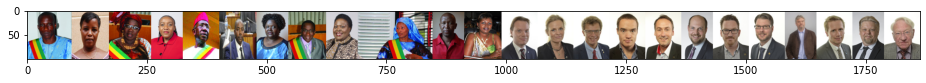

In [13]:
## test control set generation

def condition(g,s):
    return s > 3
control, lowerFS, lowerMS, upperFS, upperMS = getRandomControlSet(validation, condition)
print (lowerFS, lowerMS, upperFS, upperMS)

control, lowerFS, lowerMS, upperFS, upperMS = getGoodControlSet(validation, condition, k=24, alpha=0.5)
print (lowerFS, lowerMS, upperFS, upperMS, len(control))

thumbs = []
for elem in control:
    img = image.load_img(DATASET_PATH+elem)
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
plt.figure(figsize = (16,12))
plt.imshow(concat_image)


In [14]:
# Normalize \hat{d}(S) values
def calibrate(ys, lower, upper):
    return (ys - lower) / (upper - lower)

In [15]:
# DivScore for dataset with a given fraction of elements with z=0
def audit_for_f(test, control, lowerFS, lowerMS, upperFS, upperMS, condition, f, size):
    N = int(size*f)
    random.shuffle(test)
    dataset = []
    dataset += [imagePaths[i] for i in test if condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])][:N]
    dataset += [imagePaths[i] for i in test if not condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])][:(size-N)]
    random.shuffle(dataset)

    simMatrix = np.array([[simDict[img1][img2] for img1 in dataset] for img2 in control])
    simSum = np.mean(simMatrix, axis=1)
    fs = np.mean([simSum[i] for i in range(len(simSum)) if condition(genderLabels[control[i]], skintoneLabels[control[i]])])
    ms = np.mean([simSum[i] for i in range(len(simSum)) if not condition(genderLabels[control[i]], skintoneLabels[control[i]])])

    fs = calibrate(fs, lowerFS, upperFS)
    ms = calibrate(ms, lowerMS, upperMS)
    return fs-ms

# Combining DivScore for different datasets
def audit_all(test, control, lowerFS, lowerMS, upperFS, upperMS, condition, m=100, size=500):
    DIs = []
    for f in (np.linspace(0, 1, m)):
        DIs.append(audit_for_f(test, control, lowerFS, lowerMS, upperFS, upperMS, condition, f, size))
    return DIs

In [31]:
# Baseline - semi-supervised learning
def audit_sss(test, control, condition, f, size):
    N = int(size*f)
    random.shuffle(test)
    dataset = []
    dataset += [imagePaths[i] for i in test if condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])][:N]
    dataset += [imagePaths[i] for i in test if not condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])][:(size-N)]
    random.shuffle(dataset)
    control2 = list(control)
    
    fs, ms = 0, 0
    while True:
        sims, test2 = [], []
        for img in dataset:
            if img in control2:
                sims.append(0)
                continue
            
            sim_f = np.mean([simDict[img][img_c] for img_c in control2 if condition(genderLabels[img_c], skintoneLabels[img_c])])
            sim_m = np.mean([simDict[img][img_c] for img_c in control2 if not condition(genderLabels[img_c], skintoneLabels[img_c])])            
            sims.append((sim_f - sim_m))
        
        if sum(sims) == 0:
            break
        
        k = 5
        for _ in range(k):
            ind = np.argmax(np.abs(sims))
            control2.append(dataset[ind])
            if sims[ind] > 0:
                fs += 1
            elif sims[ind] < 0:
                ms += 1
            sims[ind] = 0
        
    return (fs-ms)/len(dataset)

def audit_all_sss(test, control, condition, m=100, size=500):
    DIs = []
    for f in tqdm(np.linspace(0, 1, m)):
#         f = 0.5
        res = audit_sss(test, control, condition, f, size)
        print (res)
        DIs.append(res)
    return DIs    

### Analysis for Gender

In [32]:
## Diversity audit for datasets with different fraction of men and women using control sets of size 50

size = 500
reps = 8
p_size = 100
def condition(g, s):
    return g == "f"
m = 11

# simFracsAll, gDIsAll, rDIsAll, SRsAll = [], [], [], []
# gDIsAll_sss, rDIsAll_sss = [], []
for _ in tqdm(range(reps)):
    indices = list(range(len(imageToFeatures)))
    random.shuffle(indices)

    test, validation = indices[p_size:], indices[:p_size]
    control, lowerFS, lowerMS, upperFS, upperMS = getRandomControlSet(validation, condition, k=50)
    rDIsAll.append(audit_all(test, control, lowerFS, lowerMS, upperFS, upperMS, condition, m))

    rDIsAll_sss.append(audit_all_sss(test, control, condition, m))

    control, lowerFS, lowerMS, upperFS, upperMS = getGoodControlSet(validation, condition, k=50, alpha=1)
    gDIsAll.append(audit_all(test, control, lowerFS, lowerMS, upperFS, upperMS, condition, m))
    gDIsAll_sss.append(audit_all_sss(test, control, condition, m))

    
gDIsAll = np.array(gDIsAll)
rDIsAll = np.array(rDIsAll)
gDIsAll_sss = np.array(gDIsAll_sss)
rDIsAll_sss = np.array(rDIsAll_sss)


-0.644
-0.488
-0.328
-0.172
-0.012
0.152
0.336
0.476
0.628
0.8
0.956



-0.644
-0.472
-0.328
-0.156
-0.004
0.152
0.296
0.496
0.604
0.792
0.96



-0.652
-0.516
-0.32
-0.132
-0.06
0.124
0.32
0.44
0.62
0.776
0.94



-0.644
-0.52
-0.332
-0.176
0.02
0.148
0.288
0.46
0.64
0.796
0.952



-0.648
-0.508
-0.356
-0.16
-0.024
0.168
0.324
0.472
0.68
0.8
0.952



-0.672
-0.512
-0.34
-0.152
0.024
0.116
0.296
0.46
0.656
0.78
0.96



-0.648
-0.472
-0.336
-0.188
0.004
0.156
0.328
0.476
0.62
0.792
0.968



-0.648
-0.472
-0.372
-0.192
0.0
0.172
0.324
0.46
0.628
0.792
0.956



-0.652
-0.48
-0.292
-0.148
0.008
0.176
0.332
0.448
0.636
0.78
0.96



-0.652
-0.5
-0.348
-0.168
-0.012
0.176
0.312
0.456
0.672
0.804
0.956



-0.7
-0.5
-0.34
-0.168
-0.02
0.152
0.296
0.464
0.62
0.796
0.952



-0.66
-0.488
-0.332
-0.184
0.012
0.136
0.292
0.468
0.616
0.788
0.952



-0.684
-0.512
-0.324
-0.18
-0.008
0.18
0.308
0.492
0.652
0.788
0.944



-0.688
-0.508
-0.344
-0.192
-0.044
0.152
0.34
0.468
0.656
0.804
0.952



-0.696
-0.476
-0.34
-0.184
0.0
0.148
0.332
0.504
0.652
0.804
0.968



-0.684
-0.532
-0.304
-0.188
0.008
0.184
0.336
0.484
0.648
0.796
0.972




In [35]:
gDIsAll = np.array(gDIsAll)
rDIsAll = np.array(rDIsAll)
gDIsAll_sss = np.array(gDIsAll_sss)
rDIsAll_sss = np.array(rDIsAll_sss)


In [20]:
## Theoretical estimate of error
delta = np.sqrt(6*np.log(20*size)/(200 * min(np.mean(mu_diff), gamma)))
delta, delta * (np.mean(mu_same) + np.mean(mu_diff))/gamma

(0.8829526858494617, 4.995094587793395)

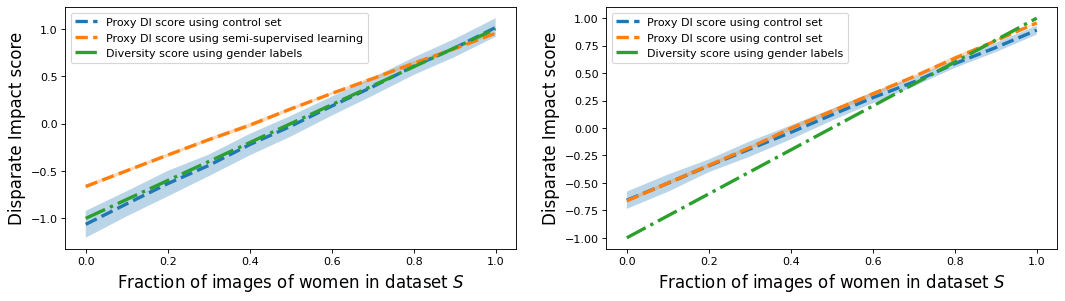

In [36]:
figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')

ax = plt.subplot(121)
ys = np.array([np.mean(rDIsAll[:,i]) for i in range(m)])
err = np.array([np.std(rDIsAll[:,i]) for i in range(m)])
xs = np.linspace(0, 1, m)
ax.plot(xs, ys, "--", label="Proxy DI score using control set", lw=3)
ax.fill_between(xs, ys-err, ys+err, alpha=0.3)

ys = np.array([np.mean(rDIsAll_sss[:,i]) for i in range(m)])
err = np.array([np.std(rDIsAll_sss[:,i]) for i in range(m)])
xs = np.linspace(0, 1, m)
ax.plot(xs, ys, "--", label="Proxy DI score using semi-supervised learning", lw=3)
ax.fill_between(xs, ys-err, ys+err, alpha=0.3)

# ys = [min(x/(1-x), (1-x)/x) if x > 0 and x < 1 else 0 for x in xs]
ys = [(2*x-1) for x in xs]
ax.plot(xs, ys, "-.", label="Diversity score using gender labels", lw=3)
ax.set_xlabel("Fraction of images of women in dataset $S$", fontsize=15)
ax.set_ylabel("Disparate Impact score", fontsize=15)
ax.legend()

ax = plt.subplot(122)
ys = np.array([np.mean(gDIsAll[:,i]) for i in range(m)])
err = np.array([np.std(gDIsAll[:,i]) for i in range(m)])
xs = np.linspace(0, 1, m)
ax.plot(xs, ys, "--", label="Proxy DI score using control set", lw=3)
ax.fill_between(xs, ys-err, ys+err, alpha=0.3)

ys = np.array([np.mean(gDIsAll_sss[:,i]) for i in range(m)])
err = np.array([np.std(gDIsAll_sss[:,i]) for i in range(m)])
xs = np.linspace(0, 1, m)
ax.plot(xs, ys, "--", label="Proxy DI score using control set", lw=3)
ax.fill_between(xs, ys-err, ys+err, alpha=0.3)

ys = [(2*x-1) for x in xs]
ax.plot(xs, ys, "-.", label="Diversity score using gender labels", lw=3)
ax.set_xlabel("Fraction of images of women in dataset $S$", fontsize=15)
ax.set_ylabel("Disparate Impact score", fontsize=15)


ax.legend()

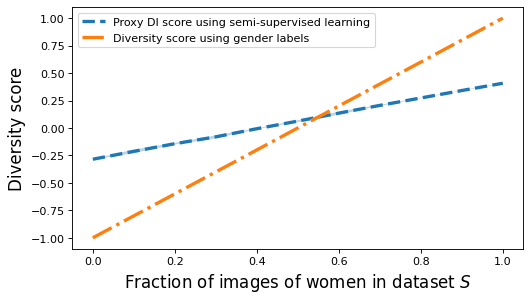

In [75]:
figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')

ax = plt.subplot(121)
ys = np.array([np.mean(rDIsAll_sss[:,i]) for i in range(m)])
err = np.array([np.std(rDIsAll_sss[:,i]) for i in range(m)])
xs = np.linspace(0, 1, m)
ax.plot(xs, ys, "--", label="Proxy DI score using semi-supervised learning", lw=3)
ax.fill_between(xs, ys-err, ys+err, alpha=0.3)

# ys = [min(x/(1-x), (1-x)/x) if x > 0 and x < 1 else 0 for x in xs]
ys = [(2*x-1) for x in xs]
ax.plot(xs, ys, "-.", label="Diversity score using gender labels", lw=3)
ax.set_xlabel("Fraction of images of women in dataset $S$", fontsize=15)
ax.set_ylabel("Diversity score", fontsize=15)
ax.legend()

# ax = plt.subplot(122)
# ys = np.array([np.mean(gDIsAll_sss[:,i]) for i in range(m)])
# err = np.array([np.std(gDIsAll_sss[:,i]) for i in range(m)])
# xs = np.linspace(0, 1, m)
# ax.plot(xs, ys, "--", label="Proxy DI score using control set", lw=3)
# ax.fill_between(xs, ys-err, ys+err, alpha=0.3)

# ys = [(2*x-1) for x in xs]
# ax.plot(xs, ys, "-.", label="Diversity score using gender labels", lw=3)
# ax.set_xlabel("Fraction of images of women in dataset $S$", fontsize=15)
# ax.set_ylabel("Disparate Impact score", fontsize=15)

In [645]:
## Diversity audit for balanced datasets using different control sets sizes

size = 500
reps = 50
p_size = 200
def condition(g, s):
    return g == "f"
m = 11
f = 0.5

def eval(dataset, control, lowerFS, lowerMS, upperFS, upperMS):
    simMatrix = np.array([[simDict[img1][img2] for img1 in dataset] for img2 in control])
    simSum = np.mean(simMatrix, axis=1)
    fs = np.mean([simSum[i] for i in range(len(simSum)) if condition(genderLabels[control[i]], skintoneLabels[control[i]])])
    ms = np.mean([simSum[i] for i in range(len(simSum)) if not condition(genderLabels[control[i]], skintoneLabels[control[i]])])

    fs = calibrate(fs, lowerFS, upperFS)
    ms = calibrate(ms, lowerMS, upperMS)
    return fs-ms

rDIsDiffF, gDIsDiffF = [], []
for _ in tqdm(range(reps)):
    indices = list(range(len(imageToFeatures)))
    random.shuffle(indices)
    test, validation = indices[p_size:], indices[:p_size]
    N = int(size*f)
    random.shuffle(test)
    dataset = []
    dataset += [imagePaths[i] for i in test if condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])][:N]
    dataset += [imagePaths[i] for i in test if not condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])][:(size-N)]
    random.shuffle(dataset)

    rDIs, gDIs = [], []
    control, lowerFS, lowerMS, upperFS, upperMS = getRandomControlSet(validation, condition, k=200)
    random.shuffle(control)
    for k in (range(12, 110, 10)):
        rDIs.append(eval(dataset, control[:k], lowerFS, lowerMS, upperFS, upperMS))

    control, lowerFS, lowerMS, upperFS, upperMS = getGoodControlSet(validation, condition, k=200, alpha=1)
    random.shuffle(control)
    for k in (range(12, 110, 10)):
        gDIs.append(eval(dataset, control[:k], lowerFS, lowerMS, upperFS, upperMS))
        
    rDIsDiffF.append(rDIs)
    gDIsDiffF.append(gDIs)
    
rDIsDiffF = np.array(rDIsDiffF)
gDIsDiffF = np.array(gDIsDiffF)


In [69]:
## DivScore-Proportional 
def getImbResults(k, condition):
    rDIsIm, rDIsCim = [], []

    for _ in tqdm(range(reps)):
        indices = list(range(len(imageToFeatures)))
        random.shuffle(indices)

        rDIs, rDIsC = [], []

        for f in np.linspace(0,1,m):    
            N = int(size*f)
            random.shuffle(indices)
            dataset = []
            dataset += [imagePaths[i] for i in indices if condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])][:N]
            dataset += [imagePaths[i] for i in indices if not condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])][:(size-N)]
            random.shuffle(dataset)

            control = dataset[:k]
            dataset = dataset[k:]
            lowerFS, lowerMS, upperFS, upperMS = getBounds(control, condition)

            simMatrix = np.array([[simDict[img1][img2] for img1 in dataset] for img2 in control])
            simSum = np.mean(simMatrix, axis=1)
            fs = np.mean([simSum[i] for i in range(len(simSum)) if condition(genderLabels[control[i]], skintoneLabels[control[i]])])
            ms = np.mean([simSum[i] for i in range(len(simSum)) if not condition(genderLabels[control[i]], skintoneLabels[control[i]])])

            fs = 0 if np.isnan(fs) else calibrate(fs, lowerFS, upperFS)
            ms = 0 if np.isnan(ms) else calibrate(ms, lowerMS, upperMS)
            rDIs.append(fs-ms)

    #         for f in np.linspace(0,1,m):
            fsc = np.mean([1 if condition(genderLabels[e], skintoneLabels[e]) else 0 for e in control])
            msc = np.mean([1 if not condition(genderLabels[e], skintoneLabels[e]) else 0 for e in control])
            rDIsC.append(fsc-msc)


        rDIsIm.append(rDIs)
        rDIsCim.append(rDIsC)

    return np.array(rDIsIm), np.array(rDIsCim)
    

size = 500
reps = 100
p_size = 200
def condition(g, s):
    return g == "f"
m = 11
k = 20
rDIsIm_50, rDIsCIm_50 = getImbResults(50, condition)


size = 500
reps = 100
p_size = 100
def condition(g, s):
    return s > 3
m = 11
rDIsIm_50_st, rDIsCIm_50_st = getImbResults(50, condition)


In [71]:
# rDIsCIm_50_st

### Analysis for Skintone

In [49]:
size = 500
reps = 90
p_size = 100
def condition(g, s):
    return s > 3
m = 11

# simFracsAll, gDIsAll_st, rDIsAll_st, SRsAll = [], [], [], []
# gDIsAll_sss_st, rDIsAll_sss_st = [], []
    
gDIsAll_st = list(gDIsAll_st)
rDIsAll_st = list(rDIsAll_st)
    
    
for _ in tqdm(range(reps)):
    indices = list(range(len(imageToFeatures)))
    random.shuffle(indices)

    test, validation = indices[p_size:], indices[:p_size]
    control, lowerFS, lowerMS, upperFS, upperMS = getRandomControlSet(validation, condition, k=50)
    rDIsAll_st.append(audit_all(test, control, lowerFS, lowerMS, upperFS, upperMS, condition, m))
#     rDIsAll_sss_st.append(audit_all_sss(test, control, condition, m))

    control, lowerFS, lowerMS, upperFS, upperMS = getGoodControlSet(validation, condition, k=50, alpha=1)
    gDIsAll_st.append(audit_all(test, control, lowerFS, lowerMS, upperFS, upperMS, condition, m))

gDIsAll_st = np.array(gDIsAll_st)
rDIsAll_st = np.array(rDIsAll_st)


Text(0, 0.5, 'Disparate Impact score')

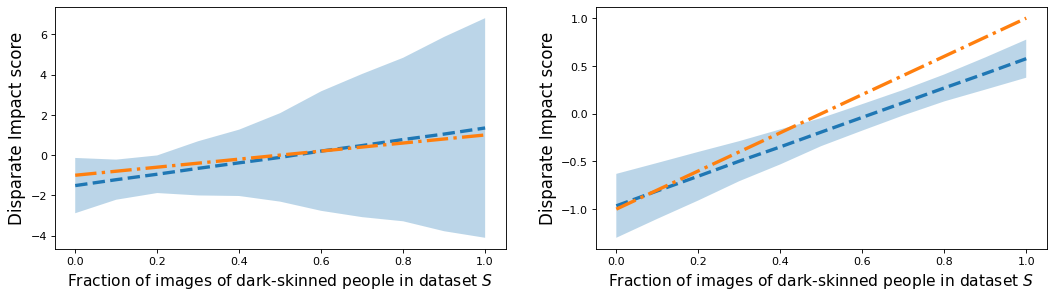

In [50]:
figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
gDIsAll_st = np.array(gDIsAll_st)
rDIsAll_st = np.array(rDIsAll_st)

ax = plt.subplot(121)
ys = np.array([np.mean(rDIsAll_st[:,i]) for i in range(m)])
# print (rDIsAll_st)
err = np.array([np.std(rDIsAll_st[:,i]) for i in range(m)])
xs = np.linspace(0, 1, m)
ax.plot(xs, ys, "--", label="Proxy DI score using control set", lw=3)
ax.fill_between(xs, ys-err, ys+err, alpha=0.3)

ys = [2*x-1 for x in xs]
ax.plot(xs, ys, "-.", label="Diversity score using skintone labels", lw=3)
ax.set_xlabel("Fraction of images of dark-skinned people in dataset $S$", fontsize=14)
ax.set_ylabel("Disparate Impact score", fontsize=15)

ax = plt.subplot(122)
ys = np.array([np.mean(gDIsAll_st[:,i]) for i in range(m)])
err = np.array([np.std(gDIsAll_st[:,i]) for i in range(m)])
xs = np.linspace(0, 1, m)
ax.plot(xs, ys, "--", label="Proxy DI score using control set", lw=3)
ax.fill_between(xs, ys-err, ys+err, alpha=0.3)

ys = [2*x-1 for x in xs]
ax.plot(xs, ys, "-.", label="Diversity score using skintone labels", lw=3)
ax.set_xlabel("Fraction of images of dark-skinned people in dataset $S$", fontsize=14)
ax.set_ylabel("Disparate Impact score", fontsize=15)
# ax.legend(fontsize=13)

In [235]:
mu_same, mu_diff = [], []
for img1 in tqdm(imagePaths):
    for img2 in imagePaths:
        if skintoneBinLabels[img1] == skintoneBinLabels[img2]:
            mu_same.append(simDict[img1][img2])
        else:
            mu_diff.append(simDict[img1][img2])
            
gamma = np.mean(mu_same) - np.mean(mu_diff)
delta = np.sqrt(6*np.log(20*size)/(len(control) * min(np.mean(mu_diff), gamma)))
gamma, delta, delta * (np.mean(mu_same) + np.mean(mu_diff))/gamma

(0.08420828820421766, 2.561745875664261, 61.11122221288563)

In [ ]:
size = 500
reps = 50
p_size = 200
def condition(g, s):
    return s>3
m = 11
f = 0.5

def eval(dataset, control, lowerFS, lowerMS, upperFS, upperMS):
    simMatrix = np.array([[simDict[img1][img2] for img1 in dataset] for img2 in control])
    simSum = np.mean(simMatrix, axis=1)
    fs = np.mean([simSum[i] for i in range(len(simSum)) if condition(genderLabels[control[i]], skintoneLabels[control[i]])])
    ms = np.mean([simSum[i] for i in range(len(simSum)) if not condition(genderLabels[control[i]], skintoneLabels[control[i]])])

    fs = calibrate(fs, lowerFS, upperFS)
    ms = calibrate(ms, lowerMS, upperMS)
    return fs-ms

rDIsDiffF_st, gDIsDiffF_st = [], []
for _ in tqdm(range(reps)):
    indices = list(range(len(imageToFeatures)))
    random.shuffle(indices)
    test, validation = indices[p_size:], indices[:p_size]
    N = int(size*f)
    random.shuffle(test)
    dataset = []
    dataset += [imagePaths[i] for i in test if condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])][:N]
    dataset += [imagePaths[i] for i in test if not condition(genderLabels[imagePaths[i]], skintoneLabels[imagePaths[i]])][:(size-N)]
    random.shuffle(dataset)

    rDIs, gDIs = [], []
    control, lowerFS, lowerMS, upperFS, upperMS = getRandomControlSet(validation, condition, k=110)
    random.shuffle(control)
    for k in (range(12, 110, 10)):
        rDIs.append(eval(dataset, control[:k], lowerFS, lowerMS, upperFS, upperMS))

    control, lowerFS, lowerMS, upperFS, upperMS = getGoodControlSet(validation, condition, k=110, alpha=1)
    random.shuffle(control)
    for k in (range(12, 110, 10)):
        gDIs.append(eval(dataset, control[:k], lowerFS, lowerMS, upperFS, upperMS))
        
    rDIsDiffF_st.append(rDIs)
    gDIsDiffF_st.append(gDIs)
    
rDIsDiffF_st = np.array(rDIsDiffF_st)
gDIsDiffF_st = np.array(gDIsDiffF_st)


In [54]:
## DivScore-Proportional

size = 550
reps = 500
p_size = 100
def condition(g, s):
    return s > 3
m = 11
# rDIsIm_20_st, rDIsCIm_20_st = getImbResults(20)
rDIsIm_50_st, rDIsCIm_50_st = getImbResults(50)
# rDIsIm_100_st, rDIsCIm_100_st = getImbResults(100)


## ALL combined results and plots

Text(0, 0.5, 'Diversity score w.r.t skintone')

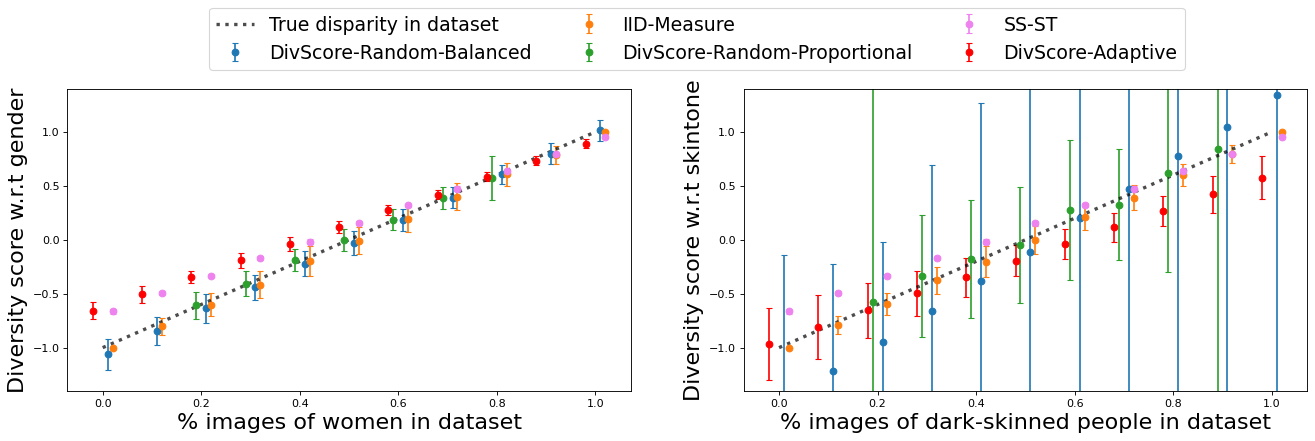

In [93]:
from matplotlib.transforms import Affine2D
figure(num=None, figsize=(20,5), dpi=80, facecolor='w', edgecolor='k')

m = 11
yl = 1.4
fs = 20
def plot1(DIs, label="", xt=0, c=None):
    ys = np.array([np.mean(DIs[:,i]) for i in range(m)])
    err = np.array([np.std(DIs[:,i]) for i in range(m)])
    xs = np.linspace(0, 1, m)
    trans = Affine2D().translate(-xt, 0.0) + ax.transData
    if c != None:
        ax.errorbar(xs, ys, err, fmt="o", label=label, transform=trans, capsize=3, capthick=1, markersize=6, color=c)
    else:
        ax.errorbar(xs, ys, err, fmt="o", label=label, transform=trans, capsize=3, capthick=1, markersize=6)
    
ax = plt.subplot(121)
xs = np.linspace(0, 1, m)
ys = [(2*x-1) for x in xs]
ax.set_ylim([-yl,yl])
plot1(rDIsAll, label="DivScore-Random-Balanced",xt=-0.01)
plot1(rDIsCIm_50, label="IID-Measure",xt=-0.02)
plot1(rDIsIm_50, label="DivScore-Random-Proportional",xt=0.01)
plot1(rDIsAll_sss, label="SS-ST",xt=-0.02, c="violet")
# plot1(gDIsAll_sss, label="SSS-Adaptive",xt=-0.02)

plot1(gDIsAll, label="DivScore-Adaptive",xt=0.02, c="red")

ax.plot(xs, ys, ":", label="True disparity in dataset", lw=3, color="black", alpha=0.7)
ax.set_xlabel("% images of women in dataset", fontsize=fs)
ax.set_ylabel("Diversity score w.r.t gender", fontsize=fs)
ax.legend(fontsize=17, bbox_to_anchor=(2,1.3), ncol=3)        

ax = plt.subplot(122)
xs = np.linspace(0, 1, m)
ys = [(2*x-1) for x in xs]
ax.set_ylim([-yl,yl])
plot1(rDIsAll_st, label="Algorithm 1 using balanced random control set",xt=-0.01)
plot1(rDIsCIm_50_st, label="iid measure",xt=-0.02)
plot1(rDIsIm_50_st, label="Algorithm 1 using imbalanced control set",xt=0.01)
plot1(rDIsAll_sss, label="SSS-Random",xt=-0.02, c="violet")

plot1(gDIsAll_st, label="Algorithm 1 using balanced adaptive control set",xt=0.02, c="red")

ax.plot(xs, ys, ":", label="True disparity in dataset", lw=3, color="black", alpha=0.7)
ax.set_xlabel("% images of dark-skinned people in dataset", fontsize=fs)
ax.set_ylabel("Diversity score w.r.t skintone", fontsize=fs)


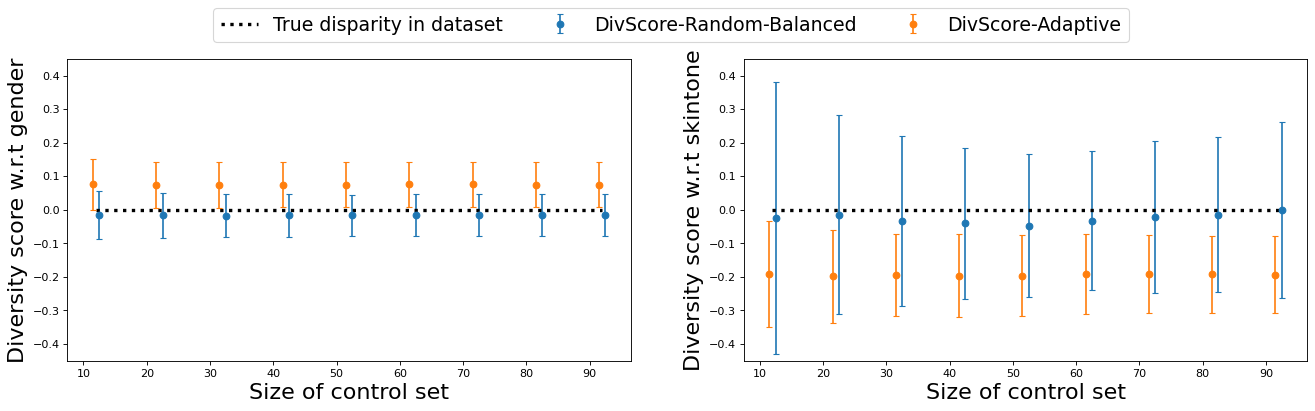

In [655]:
from matplotlib.transforms import Affine2D
figure(num=None, figsize=(20,5), dpi=80, facecolor='w', edgecolor='k')

m = 11
yl = 0.45
fs = 20
xs = list(range(12,100,10))
def plot1(DIs, label="", xt=0):
    ys = np.array([np.mean(DIs[:,i]) for i in range(len(xs))])
    err = np.array([np.std(DIs[:,i]) for i in range(len(xs))])
    trans = Affine2D().translate(-xt, 0.0) + ax.transData
    ax.errorbar(xs, ys, err, fmt="o", label=label, transform=trans, capsize=3, capthick=1, markersize=6)
    
ax = plt.subplot(121)
ys = [0 for x in xs]
ax.plot(xs, ys, ":", label="True disparity in dataset", lw=3, color="black")
ax.set_xlabel("Size of control set", fontsize=fs)
ax.set_ylabel("Diversity score w.r.t gender", fontsize=fs)
ax.set_ylim([-yl,yl])
plot1(rDIsDiffF, label="DivScore-Random-Balanced",xt=-0.5)
plot1(gDIsDiffF, label="DivScore-Adaptive",xt=0.5)
ax.legend(fontsize=17, bbox_to_anchor=(1.9,1.2), ncol=3)        

ax = plt.subplot(122)
xs = list(range(12,100,10))
ys = [0 for x in xs]
ax.plot(xs, ys, ":", label="True disparity in dataset", lw=3, color="black")
ax.set_xlabel("Size of control set", fontsize=fs)
ax.set_ylabel("Diversity score w.r.t skintone", fontsize=fs)
ax.set_ylim([-yl,yl])
plot1(rDIsDiffF_st, label="Algorithm 1 using balanced random control set",xt=-0.5)
plot1(gDIsDiffF_st, label="Algorithm 1 using balanced adaptive control set",xt=0.5)
